<a href="https://colab.research.google.com/github/mohmedelsakaty/Supply-Chain-Analysis-End-to-End/blob/main/PYTHON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [207]:



df.columns = df.columns.str.strip()
df["OrderDate"] = pd.to_datetime(df["OrderDate"])
df["OnTimeDelivery"] = df["OnTimeDelivery"].str.upper().str.strip()
df["OnTimeDeliveryBinary"] = df["OnTimeDelivery"].map({"Y": 1, "N": 0})
df["LateFlag"] = df["OnTimeDelivery"].map({"Y": 0, "N": 1})

df.info()
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   OrderID               400 non-null    object        
 1   OrderDate             400 non-null    datetime64[ns]
 2   Supplier              400 non-null    object        
 3   SKU                   400 non-null    object        
 4   ProductName           400 non-null    object        
 5   Quantity              400 non-null    int64         
 6   UnitCost              400 non-null    float64       
 7   UnitPrice             400 non-null    float64       
 8   CountryFrom           400 non-null    object        
 9   CountryTo             400 non-null    object        
 10  ShippingMethod        400 non-null    object        
 11  LeadTimeDays          400 non-null    int64         
 12  TransitTimeDays       400 non-null    int64         
 13  OnTimeDelivery      

In [208]:
# -------------------- Unit-Level Profit Calculation --------------------
df["Profit_from_units"] = (df["UnitPrice"] - df["UnitCost"]) * df["Quantity"]
df["Profit_diff"] = df["Profit"] - df["Profit_from_units"]

# -------------------- Scenario: 5% Unit Cost Reduction --------------------
df["UnitCost_5pct_down"] = df["UnitCost"] * 0.95
df["Profit_5pct_down"] = (df["UnitPrice"] - df["UnitCost_5pct_down"]) * df["Quantity"]

# -------------------- Supplier-Level Profit Comparison --------------------
supplier_profit = (
    df.groupby("Supplier", as_index=False)
      .agg(
          Profit_Before=("Profit", "sum"),
          Profit_After=("Profit_5pct_down", "sum")
      )
)

# -------------------- Profit Change Percentage --------------------
supplier_profit["Profit_Change_Pct"] = (
    (supplier_profit["Profit_After"] - supplier_profit["Profit_Before"])
    / supplier_profit["Profit_Before"] * 100
).round(2).astype(str) + "%"

supplier_profit



,Supplier,Profit_Before,Profit_After,Profit_Change_Pct
0,Atlas Supply,"1,089,642.79","1,251,908.80",14.89%
1,Delta Parts Co,"548,909.58","631,543.48",15.05%
2,Nile Components,"881,301.18","1,025,443.62",16.36%
3,TransAuto Ltd,"648,440.42","747,112.00",15.22%
4,Zenith Logistics,"703,300.46","801,965.47",14.03%


In [209]:
import pandas as pd
from sklearn.linear_model import LinearRegression



# 1) Create Profit
# ==============================
df["Profit"] = df["Revenue"] - df["TotalCost"]

# ==============================
# (2) Encode categorical variables
# ==============================
df_encoded = pd.get_dummies(
    df,
    columns=["ShippingMethod", "Supplier"],
    drop_first=True
)

# ==============================
# 3) Define features
# ==============================
features = [
    "LeadTimeDays",
    "TransitTimeDays",
    "DefectRate"
]

features += [
    col for col in df_encoded.columns
    if col.startswith("ShippingMethod_") or col.startswith("Supplier_")
]

X = df_encoded[features]
y = df_encoded["Profit"]

# ==============================
# 4) Train model
# ==============================
model = LinearRegression()
model.fit(X, y)

# ==============================
# 5) Lead-time coefficient
# ==============================
lead_coef = model.coef_[features.index("LeadTimeDays")]

# ==============================
# 6) Apply 5% lead-time reduction
# ==============================
avg_lead = df["LeadTimeDays"].mean()
reduction_days = avg_lead * 0.05

profit_gain_per_order = -lead_coef * reduction_days
total_profit_gain = profit_gain_per_order * len(df)

# ==============================
# 7) Profit % change
# ==============================
avg_profit = df["Profit"].mean()
profit_pct_change = (profit_gain_per_order / avg_profit) * 100

# ==============================
# 8) Print results
# ==============================
print(f"Profit change per 1 lead-time day: {lead_coef:.2f}")
print(f"Average lead time: {avg_lead:.2f} days")
print(f"Lead time reduced by: {reduction_days:.2f} days")

print(f"Profit increase per order: {profit_gain_per_order:.2f}")
print(f"Total profit increase (all orders): {total_profit_gain:.2f}")

print(f"Average profit per order: {avg_profit:.2f}")
print(f"Profit increase percentage: {profit_pct_change:.2f}%")


Profit change per 1 lead-time day: -423.27
Average lead time: 31.97 days
Lead time reduced by: 1.60 days
Profit increase per order: 676.59
Total profit increase (all orders): 270637.44
Average profit per order: 9678.99
Profit increase percentage: 6.99%


In [210]:
# -------------------- Product Performance --------------------

product_perf = (
    df.groupby("ProductName", as_index=False)
      .agg(
          Total_Revenue=("Revenue", "sum"),
          Total_Profit=("Profit", "sum"),
          Total_Volume=("Quantity", "sum"),
      )
)

# Profit margin (%)
product_perf["Profit_Margin_Pct"] = (
    product_perf["Total_Profit"] / product_perf["Total_Revenue"]
).mul(100)

# Final view
product_perf = product_perf[
    [
        "ProductName",
        "Profit_Margin_Pct",
        "Total_Volume",
    ]
].sort_values("Total_Volume", ascending=False)

product_perf



,ProductName,Profit_Margin_Pct,Total_Volume
0,Alternator,27.40,18316
2,Bearing,23.34,14772
3,Brake Pad,27.55,14180
1,Axle,24.18,13652
6,Radiator,21.22,11084
4,Fuel Pump,24.41,11004
5,Gearbox,21.18,8652
7,Steering Rack,24.34,4696


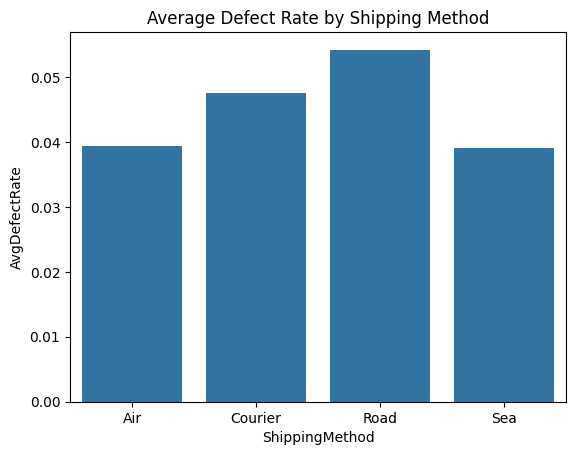

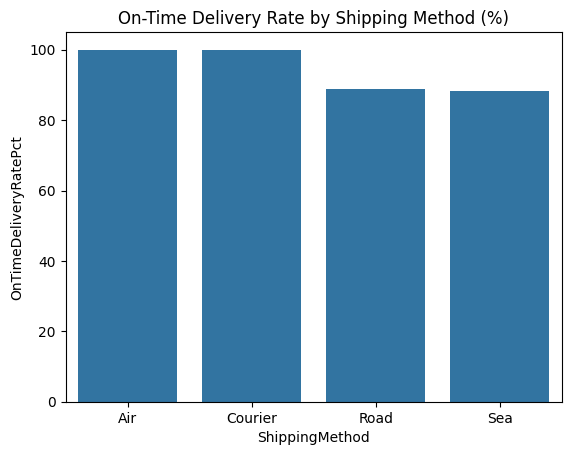

In [211]:


# Binary conversion
map_ontime = {
    "1":1,"0":0,"yes":1,"no":0,"y":1,"n":0,
    "true":1,"false":0,"on time":1,"late":0
}

df["OnTimeDeliveryBinary"] = (
    df["OnTimeDelivery"]
    .astype(str).str.strip().str.lower()
    .map(map_ontime)
)

if df["OnTimeDeliveryBinary"].isna().any():
    raise ValueError(f"Unmapped values: {df['OnTimeDelivery'].unique()}")

# Aggregate
shipping_stats = (
    df.groupby("ShippingMethod")
      .agg(
          AvgDefectRate=("DefectRate","mean"),
          OnTimeDeliveryRatePct=("OnTimeDeliveryBinary", lambda x: x.mean()*100)
      )
      .reset_index()
)

# Plots
sns.barplot(data=shipping_stats, x="ShippingMethod", y="AvgDefectRate")
plt.title("Average Defect Rate by Shipping Method")
plt.show()

sns.barplot(data=shipping_stats, x="ShippingMethod", y="OnTimeDeliveryRatePct")
plt.title("On-Time Delivery Rate by Shipping Method (%)")
plt.show()


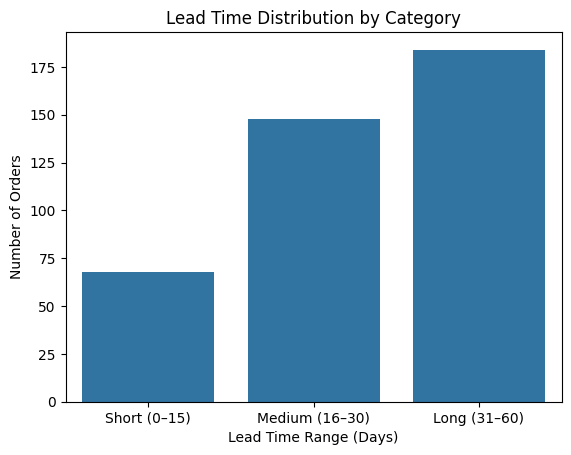

In [212]:

# Define bins
bins = [0, 15, 30, 60]
labels = ["Short (0–15)", "Medium (16–30)", "Long (31–60)"]

# Create categories
df["LeadTimeRange"] = pd.cut(
    df["LeadTimeDays"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Count orders per category
leadtime_stats = (
    df["LeadTimeRange"]
    .value_counts()
    .sort_index()
    .reset_index()
)

leadtime_stats.columns = ["LeadTimeRange", "OrderCount"]

# Plot
sns.barplot(
    data=leadtime_stats,
    x="LeadTimeRange",
    y="OrderCount"
)
plt.title("Lead Time Distribution by Category")
plt.xlabel("Lead Time Range (Days)")
plt.ylabel("Number of Orders")
plt.show()


/tmp/ipython-input-3632106573.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


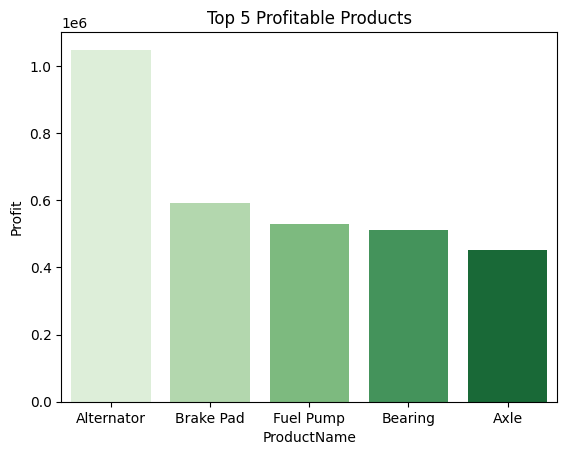

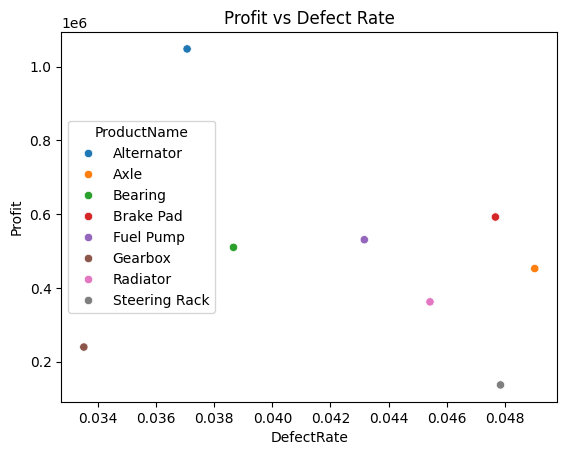

In [213]:
# -------------------- Product-Level Profit & Defect Aggregation --------------------
product_stats = (
    df.groupby("ProductName")
      .agg({"Profit": "sum", "DefectRate": "mean"})
      .reset_index()
)

# -------------------- Top 5 Products by Profit --------------------
top_products = (
    product_stats
    .sort_values("Profit", ascending=False)
    .head(5)
)

sns.barplot(
    data=top_products,
    x="ProductName",
    y="Profit",
    palette="Greens"
)
plt.title("Top 5 Profitable Products")
plt.show()

# -------------------- Profit vs Defect Rate Relationship --------------------
sns.scatterplot(
    data=product_stats,
    x="DefectRate",
    y="Profit",
    hue="ProductName"
)
plt.title("Profit vs Defect Rate")
plt.show()


/tmp/ipython-input-4082100874.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


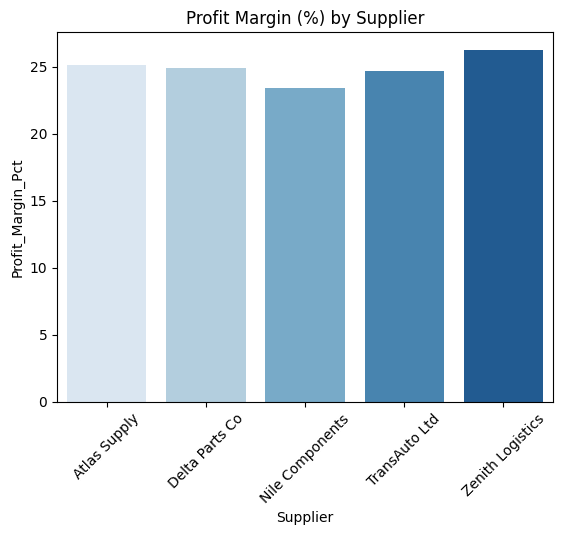

/tmp/ipython-input-4082100874.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


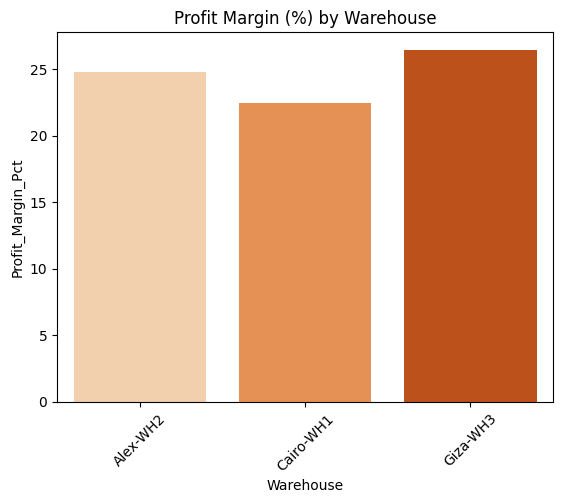

In [214]:
# -------------------- Profit Margin Analysis --------------------
for col, palette in [("Supplier", "Blues"), ("Warehouse", "Oranges")]:

    stats = (
        df.groupby(col)
          .agg({"Revenue": "sum", "Profit": "sum"})
          .reset_index()
    )

    # Profit margin (%)
    stats["Profit_Margin_Pct"] = (
        stats["Profit"] / stats["Revenue"]
    ) * 100

    sns.barplot(
        data=stats,
        x=col,
        y="Profit_Margin_Pct",
        palette=palette
    )

    plt.title(f"Profit Margin (%) by {col}")
    plt.xticks(rotation=45)
    plt.show()


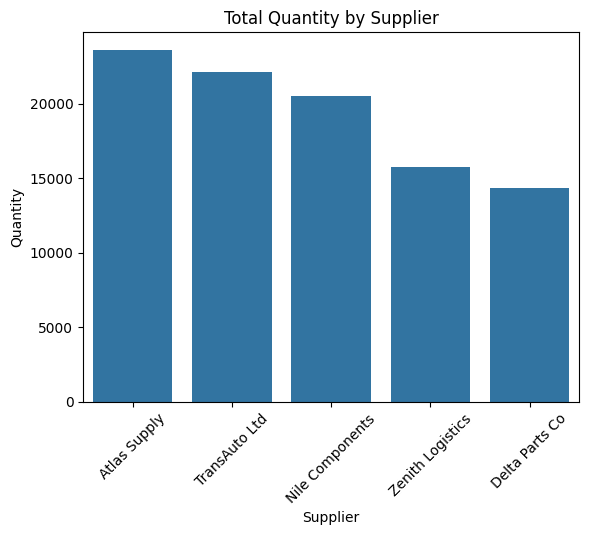

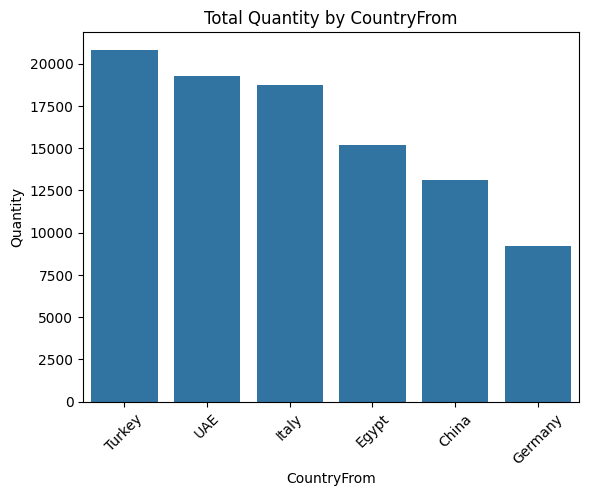

  CountryFrom  Quantity      Revenue     Profit
5         UAE     19264 3,502,448.83 929,728.85
3       Italy     18724 3,174,027.23 691,342.40
1       Egypt     15172 2,955,486.82 751,578.41
4      Turkey     20828 2,917,981.18 693,954.78
0       China     13140 1,813,454.39 460,849.99
2     Germany      9228 1,240,837.20 344,140.01


In [215]:
# -------------------- Quantity by Supplier & Country --------------------
for col in ["Supplier", "CountryFrom"]:

    qty = (
        df.groupby(col)["Quantity"]
          .sum()
          .reset_index()
          .sort_values("Quantity", ascending=False)
    )

    sns.barplot(
        data=qty,
        x=col,
        y="Quantity"
    )

    plt.title(f"Total Quantity by {col}")
    plt.xticks(rotation=45)
    plt.show()

# -------------------- Country-Level Financial Summary --------------------
country_from_stats = (
    df.groupby("CountryFrom")
      .agg(
          Quantity=("Quantity", "sum"),
          Revenue=("Revenue", "sum"),
          Profit=("Profit", "sum")
      )
      .reset_index()
      .sort_values("Revenue", ascending=False)
)

print(country_from_stats)


In [216]:
# -------------------- Shipping Method Financial Summary --------------------
method_financials = (
    df.groupby("ShippingMethod", as_index=False)
      .agg(
          Total_Revenue=("Revenue", "sum"),
          Total_Cost=("TotalCost", "sum"),
          Total_Profit=("Profit", "sum"),
          Total_Volume=("Quantity", "sum")
      )
      .sort_values("Total_Revenue", ascending=False)
)

# -------------------- Revenue & Cost Output --------------------
print(
    method_financials[
        ["ShippingMethod", "Total_Revenue", "Total_Cost"]
    ]
)


  ShippingMethod  Total_Revenue   Total_Cost
3            Sea   9,539,321.25 7,160,910.41
0            Air   2,486,116.82 1,870,946.81
2           Road   2,479,136.76 1,897,685.60
1        Courier   1,099,660.82   803,098.39


In [217]:
# -------------------- Product Revenue & Profit Share --------------------

product_perf = (
    df.groupby("ProductName", as_index=False)
      .agg(
          Revenue=("Revenue", "sum"),
          Profit=("Profit", "sum")
      )
)

# Totals
total_revenue = product_perf["Revenue"].sum()
total_profit = product_perf["Profit"].sum()

# Percentages (numeric for correct sorting)
product_perf["Revenue_Pct"] = (product_perf["Revenue"] / total_revenue) * 100
product_perf["Profit_Pct"] = (product_perf["Profit"] / total_profit) * 100

# Sort by Revenue %
product_perf = product_perf.sort_values(
    "Revenue_Pct", ascending=False
)

# Final formatted view
product_perf = product_perf[
    ["ProductName", "Revenue", "Revenue_Pct", "Profit", "Profit_Pct"]
]

product_perf["Revenue_Pct"] = product_perf["Revenue_Pct"].round(2).astype(str) + "%"
product_perf["Profit_Pct"] = product_perf["Profit_Pct"].round(2).astype(str) + "%"

product_perf


,ProductName,Revenue,Revenue_Pct,Profit,Profit_Pct
0,Alternator,"3,825,674.00",24.52%,"1,048,073.99",27.07%
2,Bearing,"2,185,022.01",14.0%,"509,894.40",13.17%
4,Fuel Pump,"2,173,463.64",13.93%,"530,631.23",13.71%
3,Brake Pad,"2,149,630.42",13.78%,"592,175.24",15.3%
1,Axle,"1,871,216.39",11.99%,"452,438.39",11.69%
6,Radiator,"1,706,410.78",10.94%,"362,071.17",9.35%
5,Gearbox,"1,130,847.61",7.25%,"239,519.62",6.19%
7,Steering Rack,"561,970.80",3.6%,"136,790.40",3.53%


In [218]:
# -------------------- Shipping Method Financial Aggregation --------------------
method_financials = (
    df.groupby("ShippingMethod", as_index=False)
      .agg(
          Total_Revenue=("Revenue", "sum"),
          Total_Cost=("TotalCost", "sum"),
          Total_Profit=("Profit", "sum"),
          Total_Volume=("Quantity", "sum")
      )
      .sort_values("Total_Revenue", ascending=False)
)

# -------------------- Revenue & Cost Output --------------------
print(
    method_financials[
        ["ShippingMethod", "Total_Revenue", "Total_Cost"]
    ]
)


  ShippingMethod  Total_Revenue   Total_Cost
3            Sea   9,539,321.25 7,160,910.41
0            Air   2,486,116.82 1,870,946.81
2           Road   2,479,136.76 1,897,685.60
1        Courier   1,099,660.82   803,098.39


/tmp/ipython-input-3897842384.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shipping_stats, x="ShippingMethod", y="DefectRate", palette="Reds")


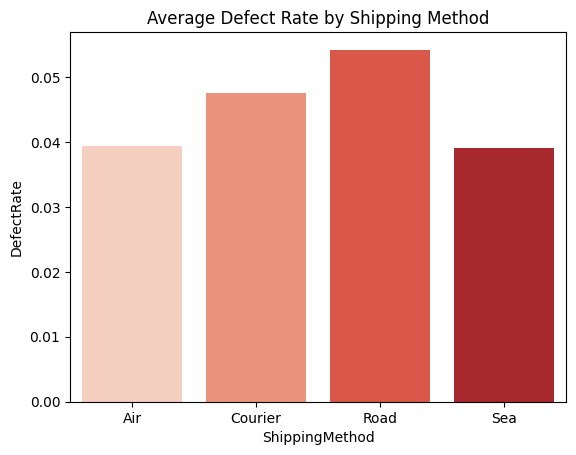

/tmp/ipython-input-3897842384.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shipping_stats, x="ShippingMethod", y="OnTimeDeliveryRatePct", palette="Blues")


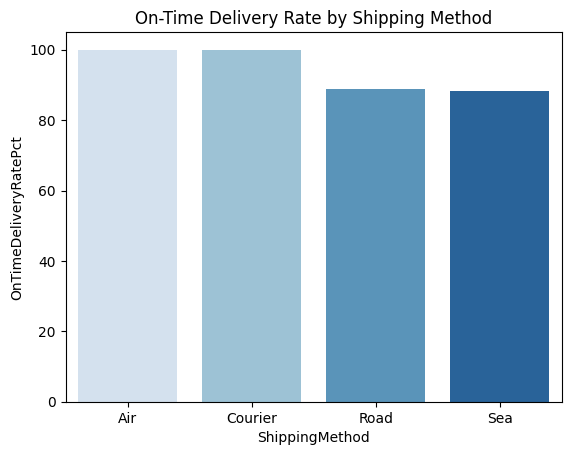

In [219]:
shipping_stats = (
    df.groupby("ShippingMethod")
      .agg({"DefectRate":"mean","OnTimeDeliveryBinary":"mean"})
      .reset_index()
)

shipping_stats["OnTimeDeliveryRatePct"] = shipping_stats["OnTimeDeliveryBinary"] * 100

sns.barplot(data=shipping_stats, x="ShippingMethod", y="DefectRate", palette="Reds")
plt.title("Average Defect Rate by Shipping Method")
plt.show()

sns.barplot(data=shipping_stats, x="ShippingMethod", y="OnTimeDeliveryRatePct", palette="Blues")
plt.title("On-Time Delivery Rate by Shipping Method")
plt.show()

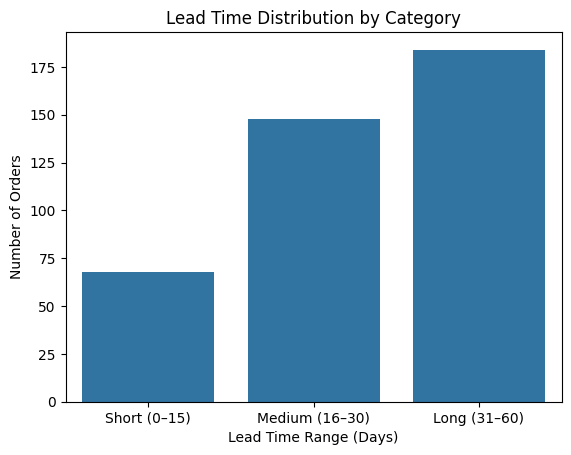

In [220]:
# ==============================
# Lead Time Distribution (3 Categories)
# ==============================

# Define lead-time bins and labels
bins = [0, 15, 30, 60]
labels = ["Short (0–15)", "Medium (16–30)", "Long (31–60)"]

# Categorize lead time into ranges
df["LeadTimeRange"] = pd.cut(
    df["LeadTimeDays"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Count number of orders per lead-time range
range_stats = (
    df["LeadTimeRange"]
    .value_counts()
    .sort_index()
    .reset_index()
)

range_stats.columns = ["LeadTimeRange", "OrderCount"]

# Plot lead-time distribution
sns.barplot(
    data=range_stats,
    x="LeadTimeRange",
    y="OrderCount"
)

plt.title("Lead Time Distribution by Category")
plt.xlabel("Lead Time Range (Days)")
plt.ylabel("Number of Orders")
plt.show()



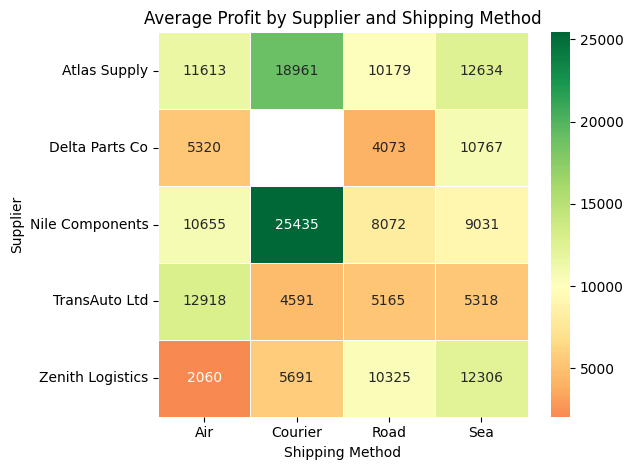

In [221]:


# ==============================
# 1) Create pivot table
# ==============================
pivot_table = (
    df.groupby(["Supplier", "ShippingMethod"])["Profit"]
      .mean()
      .reset_index()
      .pivot(index="Supplier", columns="ShippingMethod", values="Profit")
)

# ==============================
# 2) Define color scaling
# ==============================
vmin = pivot_table.min().min()
vmax = pivot_table.max().max()
vcenter = pivot_table.mean().mean()

# ==============================
# 3) Plot heatmap (BAD → GOOD)
# ==============================
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".0f",
    cmap="RdYlGn",      # 🔴 bad → 🟢 good
    vmin=vmin,
    vmax=vmax,
    center=vcenter,
    linewidths=0.5
)

plt.title("Average Profit by Supplier and Shipping Method")
plt.xlabel("Shipping Method")
plt.ylabel("Supplier")
plt.tight_layout()
plt.show()


/tmp/ipython-input-344652910.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


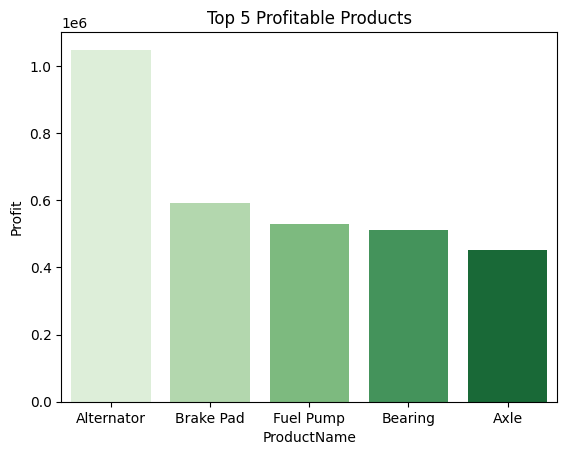

In [222]:
# -------------------- Product-Level Aggregation --------------------
product_stats = (
    df.groupby("ProductName")
      .agg({"Profit": "sum"})
      .reset_index()
)

# -------------------- Top 5 Products by Profit --------------------
top_products = product_stats.sort_values(
    "Profit", ascending=False
).head(5)

# -------------------- Profit Visualization --------------------
sns.barplot(
    data=top_products,
    x="ProductName",
    y="Profit",
    palette="Greens"
)

plt.title("Top 5 Profitable Products")
plt.show()



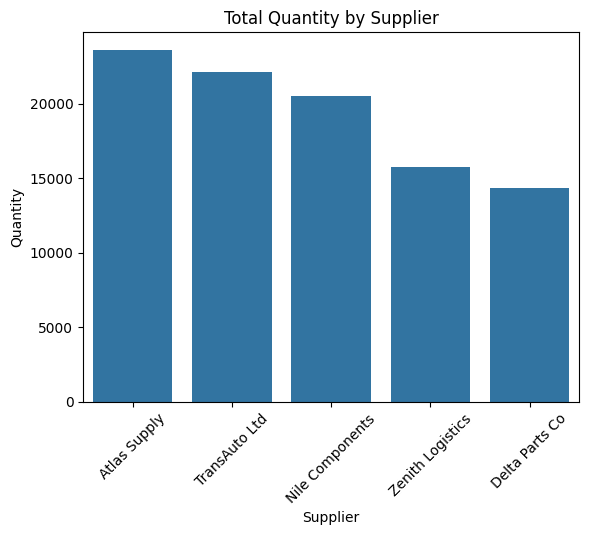

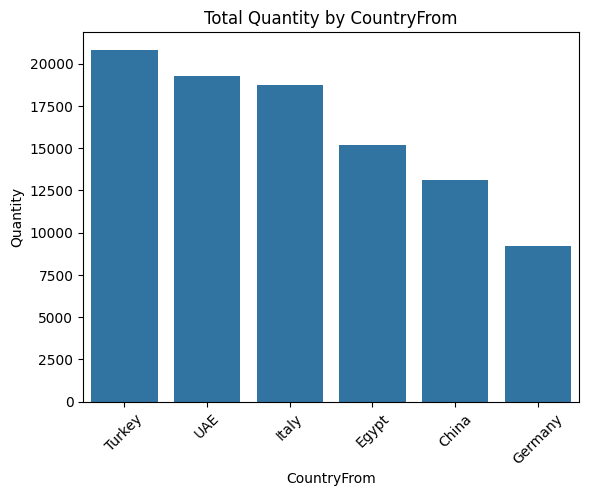

In [223]:
# -------------------- Quantity Analysis by Supplier & Country --------------------
for col in ["Supplier", "CountryFrom"]:

    # Aggregate total quantity
    qty = (
        df.groupby(col)["Quantity"]
          .sum()
          .reset_index()
          .sort_values("Quantity", ascending=False)
    )

    # Quantity bar chart
    sns.barplot(
        data=qty,
        x=col,
        y="Quantity",
        legend=False
    )

    # Chart formatting
    plt.title(f"Total Quantity by {col}")
    plt.xticks(rotation=45)
    plt.show()


In [224]:
# -------------------- Country-Level Quantity, Revenue & Profit --------------------
country_from_stats = (
    df.groupby("CountryFrom")
      .agg(
          Quantity=("Quantity", "sum"),
          Revenue=("Revenue", "sum"),
          Profit=("Profit", "sum")
      )
      .reset_index()
      .sort_values("Revenue", ascending=False)
)

print(country_from_stats)


  CountryFrom  Quantity      Revenue     Profit
5         UAE     19264 3,502,448.83 929,728.85
3       Italy     18724 3,174,027.23 691,342.40
1       Egypt     15172 2,955,486.82 751,578.41
4      Turkey     20828 2,917,981.18 693,954.78
0       China     13140 1,813,454.39 460,849.99
2     Germany      9228 1,240,837.20 344,140.01


In [225]:
start_shape = df.shape
print("START → Rows:", start_shape[0], "| Columns:", start_shape[1])


START → Rows: 400 | Columns: 28


In [226]:
end_shape = df.shape
print("END → Rows:", end_shape[0], "| Columns:", end_shape[1])


END → Rows: 400 | Columns: 28


In [228]:
# -------------------- Export & Auto-Download CSV (Google Colab) --------------------
from google.colab import files

file_name = "final_supply_chain_data.csv"

df.to_csv(
    file_name,
    index=False
)

files.download(file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>